Experiment E1-9:
- binary classification
- dataset train 3500, val 1500
- BATCH_SIZE = 20
- IMAGE_SIZE = 384
- EPOCHS = 30
- criterion = nn.BCEWithLogitsLoss()
- optimizer = Adam
- lr=1e-5
- augmentation

model:
- self.base_model(x)
- unfreeze 3 layers
- self.globalavg(x) # (2,2)
- self.flatten(x)
- self.fc(x) # (5120,512)->Dropout(0.5)->Relu->(512,1)

In [1]:
import numpy as np
import os
import sys
import glob
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader
from torchvision import transforms, models
import torchvision
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

from PIL import Image

In [2]:
# load common py
sys.path.append('../src')
import config
import common_utils
import data_utils
import train_utils
import plot_utils


In [3]:
# override config for experiment
EXP_CODE = "E1-9"
SAVE_FILENAME = f"stage1-{EXP_CODE}-metrics"

config.EPOCHS = 30
config.LEARNING_RATE = 1e-5
config.IMAGE_SIZE = 384

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

common_utils.set_seed(config.SEED)


In [5]:
df = pd.read_csv(config.TRAIN_CSV)

In [6]:
# split data into train, val, test 70/15/15
# for fast training, use only 3500 and 1500 samples for train and val

train_df, val_df, test_df, train_small_df, val_small_df = data_utils.split_data(df, config.SEED, small_train_size=3500, small_val_size=1500)

In [7]:
# create transforms
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.RandomVerticalFlip(p=0.4),
    transforms.Resize((config.IMAGE_SIZE, config.IMAGE_SIZE)),   
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_val_transform = transforms.Compose([
    transforms.Resize((config.IMAGE_SIZE, config.IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [8]:
# create datasets
train_small_dataset = data_utils.SteelDataset(df=train_small_df, 
                                    data_folder=config.IMAGE_FOLDER,
                                    transforms=train_transform,
                                    image_size=config.IMAGE_SIZE,
                                    return_tensor=True
                                    )
val_small_dataset = data_utils.SteelDataset(df=val_small_df, 
                                    data_folder=config.IMAGE_FOLDER,
                                    transforms=test_val_transform,
                                    image_size=config.IMAGE_SIZE,
                                    return_tensor=True
                                   )


In [9]:
train_small_loader = DataLoader(train_small_dataset, batch_size=config.BATCH_SIZE,
                          shuffle=True,
                          num_workers=config.NUM_WORKERS, pin_memory=True, persistent_workers=True, prefetch_factor=config.PREFETCH_FACTOR
                          )

val_small_loader = DataLoader(val_small_dataset, batch_size=config.BATCH_SIZE,
                         shuffle=False,
                         num_workers=config.NUM_WORKERS, pin_memory=True, persistent_workers=True, prefetch_factor=config.PREFETCH_FACTOR
                         )


In [10]:
# create model
class SteelModel(nn.Module):
    def __init__(self):
        super(SteelModel, self).__init__()

        self.base_model = models.mobilenet_v2(weights='IMAGENET1K_V1').features
        for param in self.base_model.parameters():
            param.requires_grad = False

        for p in self.base_model[-3:].parameters():
            p.requires_grad = True

        # Remove original classifier
        #self.base_model.classifier = nn.Identity()

        self.globalavg = nn.AdaptiveAvgPool2d((2, 2))

        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(1280 * 2 * 2, 512),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(512, 1),
        )
               

    def forward(self, x):
        x = self.base_model(x)
        #print(x.shape)
        x = self.globalavg(x)
        #print(x.shape)
        x = self.flatten(x)
        #print(x.shape)
        x = self.fc(x)
        #print(x.shape)
        return x 

In [11]:
model = SteelModel()
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config.LEARNING_RATE)

In [12]:
%%time

arr_train_acc = []
arr_train_loss = []
arr_train_precision = []
arr_train_recall = []
arr_train_f1 = []
arr_train_rocauc = []
arr_train_conf_matrix = []

arr_val_acc = []
arr_val_loss = []
arr_val_precision = []
arr_val_recall = []
arr_val_f1 = []
arr_val_rocauc = []
arr_val_conf_matrix = []

idx = 0
for epoch in range(config.EPOCHS):
    train_loss, train_all_labels, train_all_preds, train_all_probs = train_utils.train_one_epoch(model, train_small_loader, criterion, optimizer, device)
    val_loss, val_all_labels, val_all_preds, val_all_probs = train_utils.validate_one_epoch(model, val_small_loader, criterion, device)

    # train metrics
    train_accuracy = (train_all_preds == train_all_labels).mean()
    train_precision = precision_score(train_all_labels, train_all_preds)
    train_recall = recall_score(train_all_labels, train_all_preds)
    train_f1 = f1_score(train_all_labels, train_all_preds)
    train_rocauc = roc_auc_score(train_all_labels, train_all_probs)
    train_conf_matrix = confusion_matrix(train_all_labels, train_all_preds)
    train_tn, train_fp, train_fn, train_tp = train_conf_matrix.ravel()
    
    arr_train_loss.append(train_loss)
    arr_train_acc.append(train_accuracy)
    arr_train_precision.append(train_precision)
    arr_train_recall.append(train_recall)
    arr_train_f1.append(train_f1)
    arr_train_rocauc.append(train_rocauc)
    arr_train_conf_matrix.append({'tn': train_tn, 'fp': train_fp, 'fn': train_fn, 'tp': train_tp})

    # val metrics
    val_accuracy = (val_all_preds == val_all_labels).mean()
    val_precision = precision_score(val_all_labels, val_all_preds)
    val_recall = recall_score(val_all_labels, val_all_preds)
    val_f1 = f1_score(val_all_labels, val_all_preds)
    val_rocauc = roc_auc_score(val_all_labels, val_all_probs)
    val_conf_matrix = confusion_matrix(val_all_labels, val_all_preds)
    val_tn, val_fp, val_fn, val_tp = val_conf_matrix.ravel()

    arr_val_loss.append(val_loss)
    arr_val_acc.append(val_accuracy)
    arr_val_precision.append(val_precision)
    arr_val_recall.append(val_recall)
    arr_val_f1.append(val_f1)
    arr_val_rocauc.append(val_rocauc)
    arr_val_conf_matrix.append({'tn': val_tn, 'fp': val_fp, 'fn': val_fn, 'tp': val_tp})

    print(idx+1)
    print(f"Epoch {epoch+1}/{config.EPOCHS}")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.4f}")
    print(f"  Val Loss  : {val_loss:.4f} | Val Acc: {val_accuracy:.4f}")
    print(f"  Train Precision: {train_precision:.4f} | Recall: {train_recall:.4f} | F1: {train_f1:.4f} | ROC AUC: {train_rocauc:.4f}")
    print(f"  Train Confusion Matrix: TN={train_tn}, FP={train_fp}, FN={train_fn}, TP={train_tp}")
    print(f"  Val Precision: {val_precision:.4f} | Recall: {val_recall:.4f} | F1: {val_f1:.4f} | ROC AUC: {val_rocauc:.4f}")
    print(f"  Val Confusion Matrix: TN={val_tn}, FP={val_fp}, FN={val_fn}, TP={val_tp}")

    idx += 1
    #break


1
Epoch 1/30
  Train Loss: 0.5984 | Train Acc: 0.6909
  Val Loss  : 0.4891 | Val Acc: 0.7887
  Train Precision: 0.6705 | Recall: 0.8530 | F1: 0.7508 | ROC AUC: 0.7541
  Train Confusion Matrix: TN=788, FP=801, FN=281, TP=1630
  Val Precision: 0.7699 | Recall: 0.8742 | F1: 0.8188 | ROC AUC: 0.8786
  Val Confusion Matrix: TN=467, FP=214, FN=103, TP=716
2
Epoch 2/30
  Train Loss: 0.4430 | Train Acc: 0.8034
  Val Loss  : 0.3706 | Val Acc: 0.8500
  Train Precision: 0.7981 | Recall: 0.8566 | F1: 0.8264 | ROC AUC: 0.8840
  Train Confusion Matrix: TN=1175, FP=414, FN=274, TP=1637
  Val Precision: 0.8685 | Recall: 0.8547 | F1: 0.8615 | ROC AUC: 0.9277
  Val Confusion Matrix: TN=575, FP=106, FN=119, TP=700
3
Epoch 3/30
  Train Loss: 0.3584 | Train Acc: 0.8394
  Val Loss  : 0.3197 | Val Acc: 0.8607
  Train Precision: 0.8422 | Recall: 0.8687 | F1: 0.8552 | ROC AUC: 0.9239
  Train Confusion Matrix: TN=1278, FP=311, FN=251, TP=1660
  Val Precision: 0.8756 | Recall: 0.8681 | F1: 0.8719 | ROC AUC: 0.94

In [13]:
df_metrics = train_utils.build_metric_df(
    arr_train_loss, arr_train_acc, arr_train_precision, arr_train_recall, 
    arr_train_f1, arr_train_rocauc, arr_train_conf_matrix,
    arr_val_loss, arr_val_acc, arr_val_precision, arr_val_recall, 
    arr_val_f1, arr_val_rocauc, arr_val_conf_matrix
)


In [14]:
df_metrics

,train_loss,train_acc,train_precision,train_recall,train_f1,train_rocauc,train_conf_matrix,val_loss,val_acc,val_precision,...,val_rocauc,val_conf_matrix,train_tn,train_fp,train_fn,train_tp,val_tn,val_fp,val_fn,val_tp
0,0.598374,0.690857,0.670506,0.852957,0.750806,0.754112,"{'tn': 788, 'fp': 801, 'fn': 281, 'tp': 1630}",0.489094,0.788667,0.769892,...,0.878606,"{'tn': 467, 'fp': 214, 'fn': 103, 'tp': 716}",788,801,281,1630,467,214,103,716
1,0.443003,0.803429,0.798147,0.856620,0.826350,0.883971,"{'tn': 1175, 'fp': 414, 'fn': 274, 'tp': 1637}",0.370641,0.850000,0.868486,...,0.927669,"{'tn': 575, 'fp': 106, 'fn': 119, 'tp': 700}",1175,414,274,1637,575,106,119,700
2,0.358412,0.839429,0.842212,0.868655,0.855229,0.923865,"{'tn': 1278, 'fp': 311, 'fn': 251, 'tp': 1660}",0.319710,0.860667,0.875616,...,0.942652,"{'tn': 580, 'fp': 101, 'fn': 108, 'tp': 711}",1278,311,251,1660,580,101,108,711
3,0.325145,0.862857,0.864865,0.887493,0.876033,0.935728,"{'tn': 1324, 'fp': 265, 'fn': 215, 'tp': 1696}",0.296735,0.870000,0.891960,...,0.949326,"{'tn': 595, 'fp': 86, 'fn': 109, 'tp': 710}",1324,265,215,1696,595,86,109,710
4,0.300463,0.868000,0.870968,0.890110,0.880435,0.944495,"{'tn': 1337, 'fp': 252, 'fn': 210, 'tp': 1701}",0.283416,0.876667,0.909561,...,0.953046,"{'tn': 611, 'fp': 70, 'fn': 115, 'tp': 704}",1337,252,210,1701,611,70,115,704
5,0.290246,0.878857,0.884635,0.894819,0.889698,0.948289,"{'tn': 1366, 'fp': 223, 'fn': 201, 'tp': 1710}",0.271856,0.884667,0.890097,...,0.955415,"{'tn': 590, 'fp': 91, 'fn': 82, 'tp': 737}",1366,223,201,1710,590,91,82,737
6,0.259517,0.892000,0.892875,0.911565,0.902123,0.959212,"{'tn': 1380, 'fp': 209, 'fn': 169, 'tp': 1742}",0.274412,0.878667,0.915254,...,0.956985,"{'tn': 616, 'fp': 65, 'fn': 117, 'tp': 702}",1380,209,169,1742,616,65,117,702
7,0.269183,0.888286,0.896246,0.899529,0.897885,0.955442,"{'tn': 1390, 'fp': 199, 'fn': 192, 'tp': 1719}",0.265551,0.886667,0.917632,...,0.958452,"{'tn': 617, 'fp': 64, 'fn': 106, 'tp': 713}",1390,199,192,1719,617,64,106,713
8,0.258372,0.896857,0.904067,0.907378,0.905720,0.959080,"{'tn': 1405, 'fp': 184, 'fn': 177, 'tp': 1734}",0.248381,0.891333,0.901961,...,0.962083,"{'tn': 601, 'fp': 80, 'fn': 83, 'tp': 736}",1405,184,177,1734,601,80,83,736
9,0.246438,0.899429,0.900771,0.916797,0.908714,0.962946,"{'tn': 1396, 'fp': 193, 'fn': 159, 'tp': 1752}",0.242292,0.897333,0.908979,...,0.963906,"{'tn': 607, 'fp': 74, 'fn': 80, 'tp': 739}",1396,193,159,1752,607,74,80,739


In [15]:
print('Val Metrics:')
print(df_metrics[config.VAL_METRICS])
print('')
print('Val Confusion Matrix:')
print(df_metrics[config.VAL_CF])

Val Metrics:
    val_loss   val_acc  val_precision  val_recall    val_f1  val_rocauc
0   0.489094  0.788667       0.769892    0.874237  0.818754    0.878606
1   0.370641  0.850000       0.868486    0.854701  0.861538    0.927669
2   0.319710  0.860667       0.875616    0.868132  0.871858    0.942652
3   0.296735  0.870000       0.891960    0.866911  0.879257    0.949326
4   0.283416  0.876667       0.909561    0.859585  0.883867    0.953046
5   0.271856  0.884667       0.890097    0.899878  0.894961    0.955415
6   0.274412  0.878667       0.915254    0.857143  0.885246    0.956985
7   0.265551  0.886667       0.917632    0.870574  0.893484    0.958452
8   0.248381  0.891333       0.901961    0.898657  0.900306    0.962083
9   0.242292  0.897333       0.908979    0.902320  0.905637    0.963906
10  0.253698  0.894000       0.925258    0.876679  0.900313    0.962326
11  0.238092  0.903333       0.928753    0.891331  0.909657    0.965606
12  0.241771  0.896667       0.874718    0.946276  

In [16]:
df_metrics.describe()

,train_loss,train_acc,train_precision,train_recall,train_f1,train_rocauc,val_loss,val_acc,val_precision,val_recall,val_f1,val_rocauc,train_tn,train_fp,train_fn,train_tp,val_tn,val_fp,val_fn,val_tp
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,0.237575,0.899857,0.902440,0.918542,0.910058,0.959338,0.250216,0.897178,0.912119,0.899512,0.905409,0.961933,1394.166667,194.833333,155.666667,1755.333333,609.066667,71.933333,82.300000,736.700000
std,0.095483,0.050565,0.054545,0.026699,0.041057,0.044496,0.058669,0.027871,0.033860,0.025242,0.024113,0.019043,132.512090,132.512090,51.020843,51.020843,32.317320,32.317320,20.673405,20.673405
min,0.146654,0.690857,0.670506,0.852957,0.750806,0.754112,0.206793,0.788667,0.769892,0.854701,0.818754,0.878606,788.000000,98.000000,89.000000,1630.000000,467.000000,38.000000,44.000000,700.000000
25%,0.179067,0.893214,0.897377,0.908425,0.903022,0.959113,0.215189,0.887833,0.907850,0.874847,0.896297,0.959360,1391.500000,132.250000,123.250000,1736.000000,603.250000,53.750000,69.500000,716.500000
50%,0.213301,0.913429,0.917218,0.925693,0.921157,0.972103,0.226485,0.905667,0.919588,0.904151,0.911408,0.968294,1430.000000,159.000000,142.000000,1769.000000,617.500000,63.500000,78.500000,740.500000
75%,0.259231,0.926214,0.930876,0.935505,0.932690,0.980345,0.262588,0.915667,0.932796,0.915140,0.923316,0.972433,1456.750000,197.500000,175.000000,1787.750000,627.250000,77.750000,102.500000,749.500000
max,0.598374,0.946571,0.948958,0.953428,0.951188,0.986766,0.489094,0.922000,0.949602,0.946276,0.927911,0.974800,1491.000000,801.000000,281.000000,1822.000000,643.000000,214.000000,119.000000,775.000000


In [17]:
print(df_metrics.describe())

       train_loss  train_acc  train_precision  train_recall   train_f1  \
count   30.000000  30.000000        30.000000     30.000000  30.000000   
mean     0.237575   0.899857         0.902440      0.918542   0.910058   
std      0.095483   0.050565         0.054545      0.026699   0.041057   
min      0.146654   0.690857         0.670506      0.852957   0.750806   
25%      0.179067   0.893214         0.897377      0.908425   0.903022   
50%      0.213301   0.913429         0.917218      0.925693   0.921157   
75%      0.259231   0.926214         0.930876      0.935505   0.932690   
max      0.598374   0.946571         0.948958      0.953428   0.951188   

       train_rocauc   val_loss    val_acc  val_precision  val_recall  \
count     30.000000  30.000000  30.000000      30.000000   30.000000   
mean       0.959338   0.250216   0.897178       0.912119    0.899512   
std        0.044496   0.058669   0.027871       0.033860    0.025242   
min        0.754112   0.206793   0.788667    

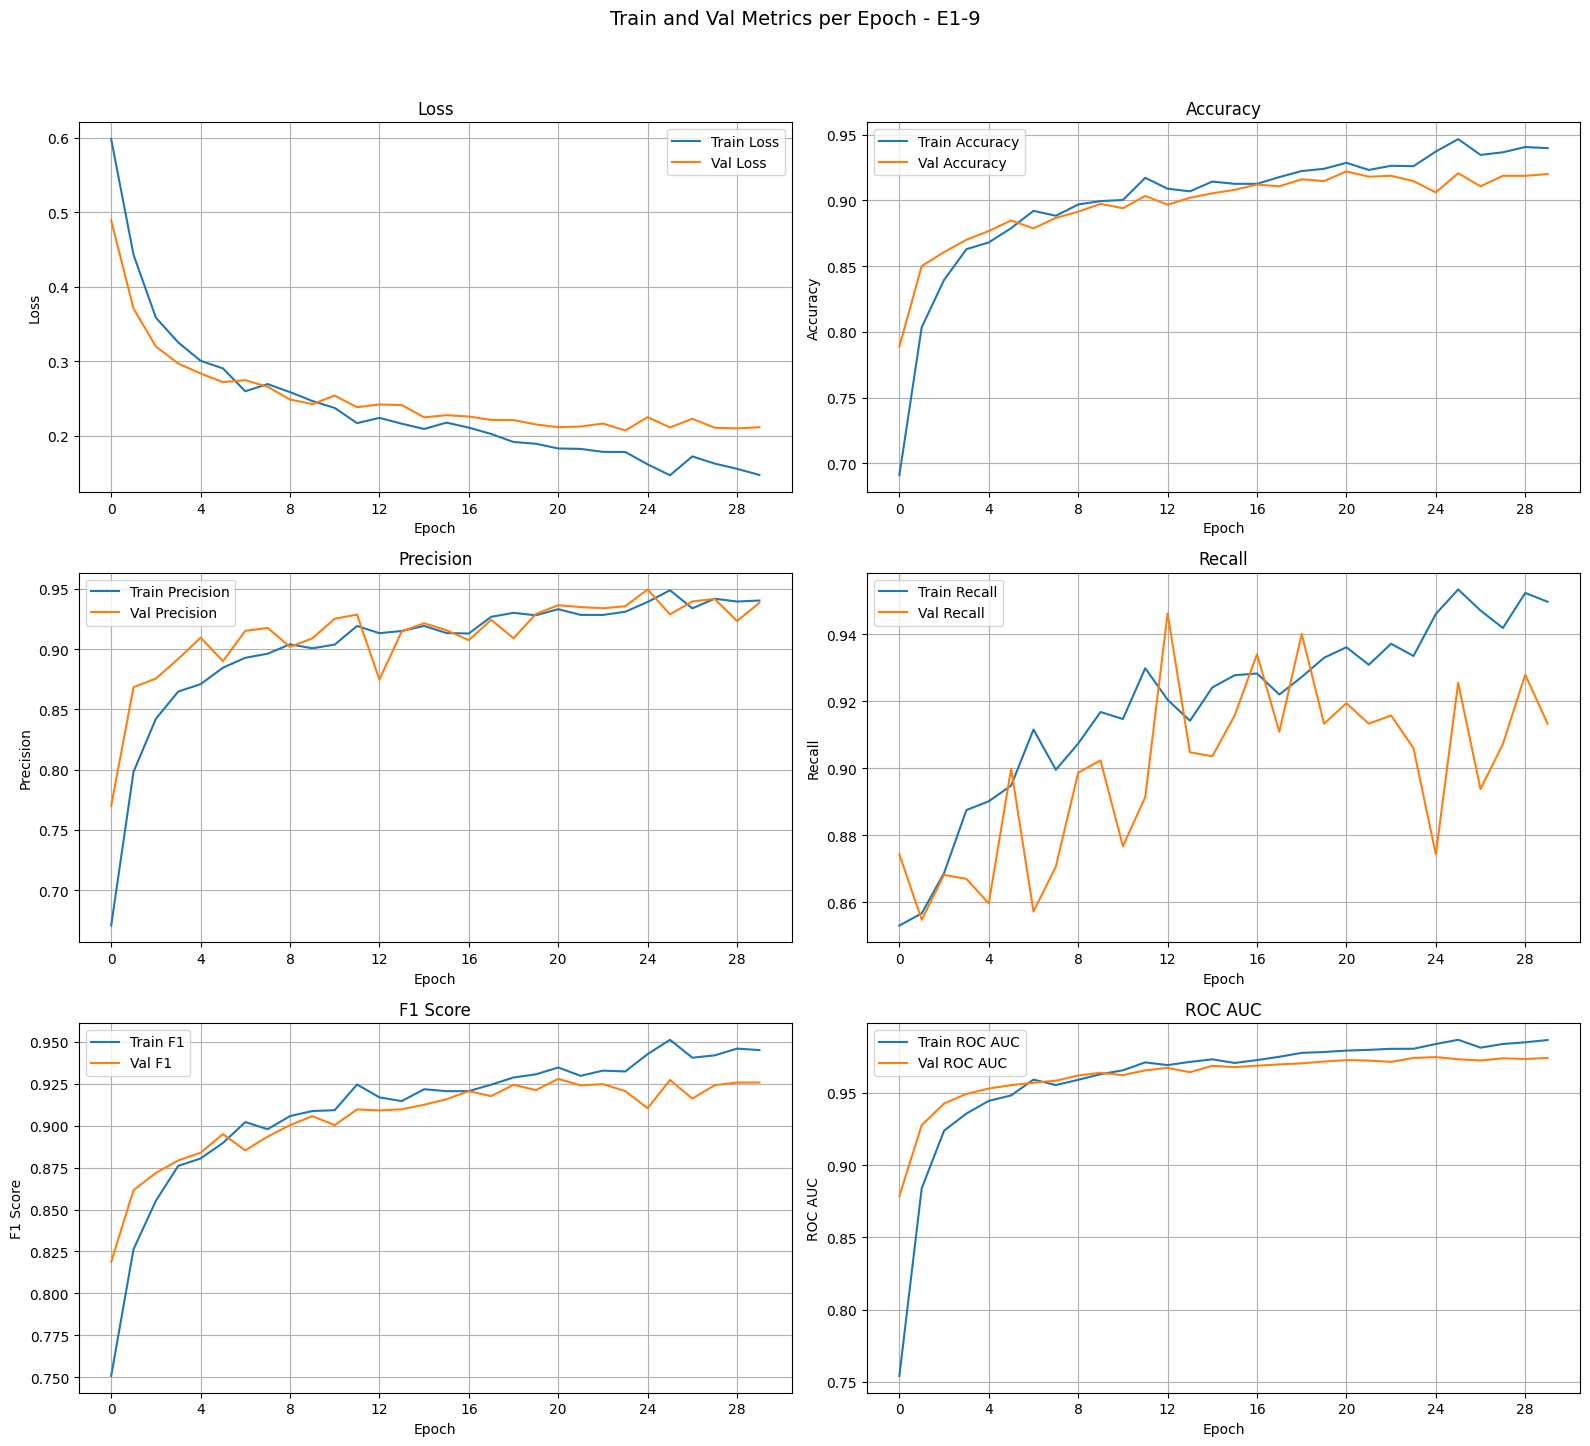

In [18]:
plot_utils.plot_train_val_metrics(df_metrics, exp_code=EXP_CODE, save_path=SAVE_FILENAME+".png")

In [19]:
df_train_conf_matrix = df_metrics['train_conf_matrix'].apply(lambda x: pd.Series([x['tn'], x['fp'], x['fn'], x['tp']]))
df_val_conf_matrix = df_metrics['val_conf_matrix'].apply(lambda x: pd.Series([x['tn'], x['fp'], x['fn'], x['tp']]))
#df_metrics[['val_tn', 'val_fp', 'val_fn', 'val_tp']]
df_train_conf_matrix.columns = ['train_tn', 'train_fp', 'train_fn', 'train_tp']
df_val_conf_matrix.columns = ['val_tn', 'val_fp', 'val_fn', 'val_tp']



In [20]:
df_train_conf_matrix.describe()

,train_tn,train_fp,train_fn,train_tp
count,30.000000,30.000000,30.000000,30.000000
mean,1394.166667,194.833333,155.666667,1755.333333
std,132.512090,132.512090,51.020843,51.020843
min,788.000000,98.000000,89.000000,1630.000000
25%,1391.500000,132.250000,123.250000,1736.000000
50%,1430.000000,159.000000,142.000000,1769.000000
75%,1456.750000,197.500000,175.000000,1787.750000
max,1491.000000,801.000000,281.000000,1822.000000


In [21]:
df_val_conf_matrix.describe()

,val_tn,val_fp,val_fn,val_tp
count,30.000000,30.000000,30.000000,30.000000
mean,609.066667,71.933333,82.300000,736.700000
std,32.317320,32.317320,20.673405,20.673405
min,467.000000,38.000000,44.000000,700.000000
25%,603.250000,53.750000,69.500000,716.500000
50%,617.500000,63.500000,78.500000,740.500000
75%,627.250000,77.750000,102.500000,749.500000
max,643.000000,214.000000,119.000000,775.000000


In [22]:
df_metrics.to_csv(SAVE_FILENAME+".csv", index=False)